In [7]:
import torch
from models import Generator
gaf_generator = Generator()
gaf_generator.load_state_dict(torch.load('models/last/g0.pt'))
gaf_generator.eval()

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (cnn): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Tanh()
  )
)

In [8]:
from dataset import ForexGafData
import pandas as pd
df = pd.read_csv('data/eurusd_minute.csv')
print('Loaded csv')
forex_data = ForexGafData(df.BidClose.values, 64)

Loaded csv


In [9]:
from transforms import reverse_gaf, reverse_noisy_gaf
import numpy as np
import matplotlib.pyplot as plt

def gen_logs(n):
    x = torch.randn(n, 100)
    gafs = gaf_generator(x).squeeze()
    log_prices = np.array([reverse_noisy_gaf(mat).detach().numpy() for mat in gafs])
    return log_prices

def gen_diag_logs(n):
    x = torch.randn(n, 100)
    gafs = gaf_generator(x).squeeze()
    log_prices = reverse_gaf(gafs).detach().numpy() 
    return log_prices

def norm_ret(log_prices):
    returns = np.diff(log_prices, axis=1)
    return returns

In [12]:
from transforms import reverse_gaf
import numpy as np

n = 1000

idx = np.random.choice(range(len(forex_data)-n), n, replace=False)

real_logs = reverse_gaf(forex_data[idx]).numpy()
real_returns = norm_ret(real_logs).reshape(-1)

fake_logs = gen_logs(n)
fake_returns = norm_ret(fake_logs).reshape(-1)

fake_logs_diag = gen_diag_logs(n)
fake_returns_diag = norm_ret(fake_logs_diag).reshape(-1)

from scipy.stats import wasserstein_distance
w_distance = wasserstein_distance(real_returns, fake_returns)
w_distance_diag = wasserstein_distance(real_returns, fake_returns_diag)
print(f'Wasserstein distance: {w_distance:.4f}')
print(f'Wasserstein distance (diagonal decoding): {w_distance_diag:.4f}')

Wasserstein distance: 0.0157
Wasserstein distance (diagonal decoding): 0.0388


<Figure size 800x640 with 0 Axes>

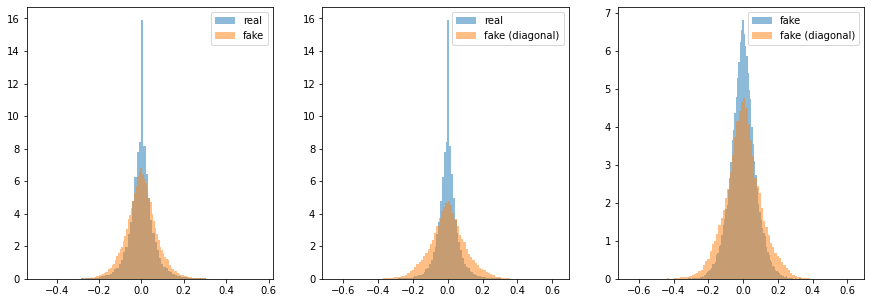

In [13]:
from os import devnull
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)

fig, (ax1,ax2,ax3) = plt.subplots(1,3)


ax1.hist(real_returns, bins=100, alpha=0.5, label='real', density=True)
ax1.hist(fake_returns, bins=100, alpha=0.5, label='fake', density=True)
ax1.legend()

ax2.hist(real_returns, bins=100, alpha=0.5, label='real', density=True)
ax2.hist(fake_returns_diag, bins=100, alpha=0.5, label='fake (diagonal)', density=True)
ax2.legend()

ax3.hist(fake_returns, bins=100, alpha=0.5, label='fake', density=True)
ax3.hist(fake_returns_diag, bins=100, alpha=0.5, label='fake (diagonal)', density=True)
ax3.legend()

# set fig size
fig.set_size_inches(15, 5)

plt.show()